### Mount Drive and create insital structre








In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

BASE_DIR = Path('/content/drive/MyDrive/Music_Genre_Classification')
DATA_RAW = BASE_DIR / 'data_raw'
DATA_SPEC = BASE_DIR / 'data_spectrograms_v2'
MODELS_DIR = BASE_DIR / 'models'

for p in [DATA_RAW, DATA_SPEC, MODELS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

BASE_DIR
DATA_SPEC

Mounted at /content/drive


PosixPath('/content/drive/MyDrive/Music_Genre_Classification/data_spectrograms_v2')

###Download FMA small Dataset from the offical github repo

In [ ]:
%cd {DATA_RAW}

!wget -O fma_metadata.zip https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
!wget -O fma_small.zip    https://os.unil.cloud.switch.ch/fma/fma_small.zip


In [ ]:
!unzip -q fma_metadata.zip
!unzip -q fma_small.zip

### Load Metadata Files
Load FMA metadata and inspect structure.

In [3]:
import pandas as pd

tracks_csv = DATA_RAW / 'fma_metadata' / 'tracks.csv'
tracks = pd.read_csv(tracks_csv, index_col=0, header=[0, 1])

tracks.head()


album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                                    <p></p>    6073   
10               4  6                                        NaN   47632   
20               2  4  <p> "spiritual songs" from Nicky Cook</p>    2710   

                        ...       track                         \
         producer tags  ... information interest language_code   
track_id                ...                                      
2             NaN   []  ...         NaN     4656            en   
3             NaN   []  ...         NaN     1470            en   
5             NaN   []  ...         NaN     1933            en   
10            NaN   []  ...         NaN    54881            en   
20            NaN   []  ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [4]:
# Get subset (small/medium/large/full)
subset = tracks[('set', 'subset')]
# Get top-level genre (8 broad genres)
genre_top = tracks[('track', 'genre_top')]

meta = pd.DataFrame({
    'subset': subset,
    'genre_top': genre_top
})
meta.head()


,subset,genre_top
track_id,,
2,small,Hip-Hop
3,medium,Hip-Hop
5,small,Hip-Hop
10,small,Pop
20,large,NaN


In [5]:
small = meta[meta['subset'] == 'small'].copy()
small = small[small['genre_top'].notna()]  # drop tracks with no top genre
print(len(small))
small['genre_top'].value_counts()


8000


,count
genre_top,
Hip-Hop,1000
Pop,1000
Folk,1000
Experimental,1000
Rock,1000
International,1000
Electronic,1000
Instrumental,1000


In [ ]:
small.to_csv(BASE_DIR / 'fma_small_tracks_genre_top.csv')


In [6]:
from pathlib import Path

AUDIO_DIR = DATA_RAW / 'fma_small'

def track_id_to_path(track_id: int) -> Path:
    tid_str = f"{track_id:06d}"         # zero-pad to 6 digits
    folder = tid_str[:3]               # first 3 digits
    return AUDIO_DIR / folder / f"{tid_str}.mp3"

# Quick sanity check
example_id = small.index[0]
print(example_id, "->", track_id_to_path(example_id))


2 -> /content/drive/MyDrive/Music_Genre_Classification/data_raw/fma_small/000/000002.mp3


### Train/Valid/Test Split
Split the metadata into train, valid, and test sets.

In [7]:
from sklearn.model_selection import train_test_split

df_small = small.reset_index().rename(columns={'index': 'track_id'})

train_df, temp_df = train_test_split(
    df_small,
    test_size=0.30,
    stratify=df_small['genre_top'],
    random_state=42
)

valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['genre_top'],
    random_state=42
)

print(len(train_df), len(valid_df), len(test_df))
print(train_df['genre_top'].value_counts())


5600 1200 1200
genre_top
Folk             700
Electronic       700
Experimental     700
Pop              700
International    700
Hip-Hop          700
Instrumental     700
Rock             700
Name: count, dtype: int64


In [8]:
splits_dir = BASE_DIR / 'splits'
AUDIO_DIR  = DATA_RAW / 'fma_small'
splits_dir.mkdir(exist_ok=True)

train_df.to_csv(splits_dir / 'train_tracks.csv', index=False)
valid_df.to_csv(splits_dir / 'valid_tracks.csv', index=False)
test_df.to_csv(splits_dir / 'test_tracks.csv', index=False)


### Create Spectrogram Folder Structure
One folder per genre per dataset split.

In [9]:
DATA_SPEC.mkdir(parents=True, exist_ok=True)

all_genres = sorted(train_df['genre_top'].unique())
all_genres


['Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Pop',
 'Rock']

In [10]:
for split in ['train', 'valid', 'test']:
    for g in all_genres:
        (DATA_SPEC / split / g).mkdir(parents=True, exist_ok=True)


### Define Function: Audio → (6s, 256 mels, 3-channel: mel + mfcc + chroma)
Core preprocessing step for converting raw audio.

In [11]:
import gc
from pathlib import Path

import librosa
import numpy as np
from PIL import Image


def _normalize_to_01(x):
    x_min, x_max = x.min(), x.max()
    if x_max - x_min < 1e-8:
        return np.zeros_like(x)
    return (x - x_min) / (x_max - x_min)


def _upsample_to_match_height(arr, target_h):
    """Repeat rows to reach target_h (simple & fast)."""
    h, w = arr.shape
    if h == target_h:
        return arr
    repeat = int(np.ceil(target_h / h))
    arr_rep = np.repeat(arr, repeat, axis=0)
    return arr_rep[:target_h, :]


def audio_to_spectrogram_chunks(
    audio_path: Path,
    out_dir: Path,
    clip_duration: float = 6.0,   # <-- longer context
    sr: int = 22050,
    n_mels: int = 256,            # <-- higher mel resolution
    hop_length: int = 512,
    top_db: float = 80.0,
) -> int:
    """
    Convert an audio file into multiple 3-channel PNGs (mel + mfcc + chroma),
    one per fixed-length clip.

    - 6-second chunks
    - Mel-spectrogram in dB (n_mels=256)
    - MFCC and chroma resized/upsampled to match mel height
    - All three normalized to [0,1] and stacked as RGB channels
    """

    try:
        y, sr = librosa.load(audio_path, sr=sr, mono=True)
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return 0

    clip_len = int(clip_duration * sr)
    num_clips = len(y) // clip_len
    if num_clips == 0:
        return 0

    out_dir.mkdir(parents=True, exist_ok=True)
    saved = 0

    for i in range(num_clips):
        clip = y[i * clip_len : (i + 1) * clip_len]

        # --- Mel spectrogram ---
        S_mel = librosa.feature.melspectrogram(
            y=clip,
            sr=sr,
            n_mels=n_mels,
            hop_length=hop_length,
            power=2.0,
        )
        S_mel_db = librosa.power_to_db(S_mel, ref=np.max, top_db=top_db)  # [-top_db, 0]
        mel_norm = _normalize_to_01(S_mel_db)  # [0,1]
        H, W = mel_norm.shape

        # --- MFCC ---
        mfcc = librosa.feature.mfcc(
            y=clip,
            sr=sr,
            n_mfcc=40,             # original MFCC dimension
            hop_length=hop_length,
        )  # shape (40, T) with same T=W
        mfcc_norm = _normalize_to_01(mfcc)
        mfcc_up = _upsample_to_match_height(mfcc_norm, H)  # (H, W)

        # --- Chroma ---
        chroma = librosa.feature.chroma_stft(
            y=clip,
            sr=sr,
            hop_length=hop_length,
        )  # shape (12, T)
        chroma_norm = _normalize_to_01(chroma)
        chroma_up = _upsample_to_match_height(chroma_norm, H)  # (H, W)

        # Stack channels: [mel, mfcc, chroma] -> (H, W, 3)
        stacked = np.stack(
            [mel_norm, mfcc_up, chroma_up],
            axis=-1
        )  # [0,1]

        # To uint8
        stacked_uint8 = (stacked * 255).astype("uint8")
        img = Image.fromarray(stacked_uint8, mode="RGB")

        fname = f"{audio_path.stem}_chunk{i:02d}.png"
        out_path = out_dir / fname
        img.save(out_path)

        saved += 1

        # cleanup
        del clip, S_mel, S_mel_db, mel_norm, mfcc, mfcc_norm, mfcc_up
        del chroma, chroma_norm, chroma_up, stacked, stacked_uint8, img
        gc.collect()

    del y
    gc.collect()
    return saved


### Generate All Spectrograms
Convert audio clips into mel-spectrogram image chunks.

In [12]:
from tqdm.auto import tqdm

def generate_split_spectrograms_v2(split_name: str, df: pd.DataFrame):
    print(f"=== Generating V2 spectrograms for {split_name} ({len(df)} tracks) ===")

    total_images = 0

    for _, row in tqdm(df.iterrows(), total=len(df)):
        track_id  = int(row['track_id'])
        genre     = row['genre_top']
        audio_p   = track_id_to_path(track_id)
        out_dir   = DATA_SPEC / split_name / genre

        if not audio_p.exists():
            continue

        total_images += audio_to_spectrogram_chunks(audio_p, out_dir)

    print(f"{split_name}: saved {total_images} V2 spectrogram images.")


generate_split_spectrograms_v2('train', train_df)
generate_split_spectrograms_v2('valid', valid_df)
generate_split_spectrograms_v2('test',  test_df)

=== Generating V2 spectrograms for train (5600 tracks) ===


  0%|          | 0/5600 [00:00<?, ?it/s]

/tmp/ipython-input-1765881290.py:101: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(stacked_uint8, mode="RGB")
/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/tmp/ipython-input-1765881290.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading /content/drive/MyDrive/Music_Genre_Classification/data_raw/fma_small/108/108925.mp3: 


/tmp/ipython-input-1765881290.py:101: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(stacked_uint8, mode="RGB")
/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/tmp/ipython-input-1765881290.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1765881290.py:101: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(stacked_uint8, mode="RGB")
/usr/local/lib/python3.12/dist-packages/librosa/core/pi

train: saved 24726 V2 spectrogram images.
=== Generating V2 spectrograms for valid (1200 tracks) ===


  0%|          | 0/1200 [00:00<?, ?it/s]

/tmp/ipython-input-1765881290.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading /content/drive/MyDrive/Music_Genre_Classification/data_raw/fma_small/133/133297.mp3: 


/tmp/ipython-input-1765881290.py:101: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(stacked_uint8, mode="RGB")
/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/tmp/ipython-input-1765881290.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1765881290.py:101: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(stacked_uint8, mode="RGB")
/usr/local/lib/python3.12/dist-packages/librosa/core/pi

valid: saved 5291 V2 spectrogram images.
=== Generating V2 spectrograms for test (1200 tracks) ===


  0%|          | 0/1200 [00:00<?, ?it/s]

/tmp/ipython-input-1765881290.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1765881290.py:101: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(stacked_uint8, mode="RGB")
/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/tmp/ipython-input-1765881290.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.co

Error loading /content/drive/MyDrive/Music_Genre_Classification/data_raw/fma_small/099/099134.mp3: 


/tmp/ipython-input-1765881290.py:101: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(stacked_uint8, mode="RGB")
/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


test: saved 5309 V2 spectrogram images.


### Quick Sanity Check
Visualize a batch to verify spectrograms and labels.

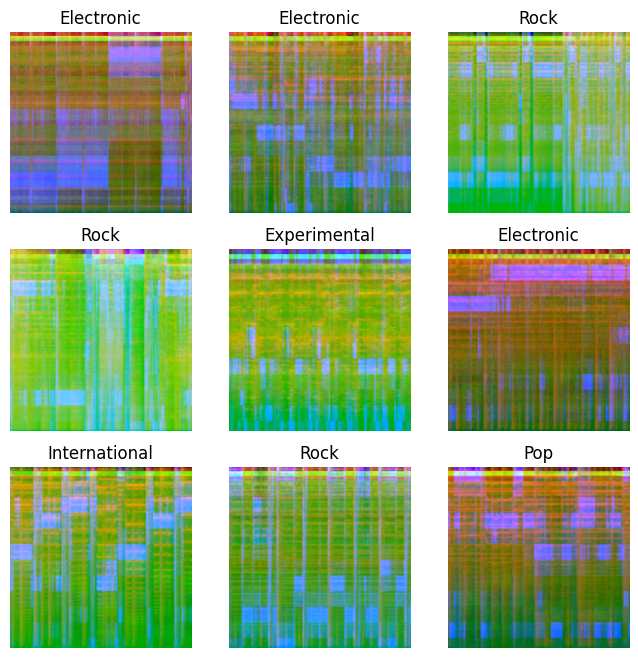

In [13]:
from fastai.vision.all import *

spec_train_root = DATA_SPEC / 'train'

dls_check = ImageDataLoaders.from_folder(
    spec_train_root,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(224)
)

dls_check.show_batch(max_n=9, figsize=(8, 8))
